In [14]:
import os, sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Activation, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split

physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(f'Running on Python {sys.version}, Tensorflow {tf.__version__}.')

Running on Python 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)], Tensorflow 2.5.0.


In [19]:
DataPath = 'Dataset'
maskImage = DataPath + '/with_mask'
unmaskImage = DataPath + '/without_mask'
data, labels = [], []
img_height, img_width = 224, 224

In [20]:
for imagePath in os.listdir(maskImage):
    label = '1'  # with mask
    image = load_img(os.path.join(maskImage,imagePath), target_size=(img_height, img_width))
    image = preprocess_input(img_to_array(image))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

for imagePath in os.listdir(unmaskImage):
    label = '0'  # without mask
    image = load_img(os.path.join(unmaskImage,imagePath), target_size=(img_height, img_width))
    image = preprocess_input(img_to_array(image))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
    break

data = np.array(data, dtype="float32")
labels = to_categorical(np.array(labels))
assert len(data) == len(labels), 'Length of data and labels mismatch!'
print(f'{len(data)} images loaded from {DataPath}')

c:\users\alien\documents\pycharm projects\venv\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11162 images loaded from Dataset


In [7]:
train_x, test_x, train_y, test_y = train_test_split(data, labels, test_size=0.15, stratify=labels, shuffle=True, random_state=69)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.20, stratify=train_y, shuffle=True, random_state=69)

In [5]:
ImageGen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

In [6]:
mobile_net_v2 = MobileNetV2(weights="imagenet", alpha=1.0, input_shape=(img_height, img_width, 3), include_top=False)
mobile_net_v2.trainable = False

xInput = Input((img_height, img_width, 3))
x = mobile_net_v2(xInput)
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten()(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
xOutput = Dense(2)(x)  # no activation as using logit

model = Model(xInput, xOutput)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

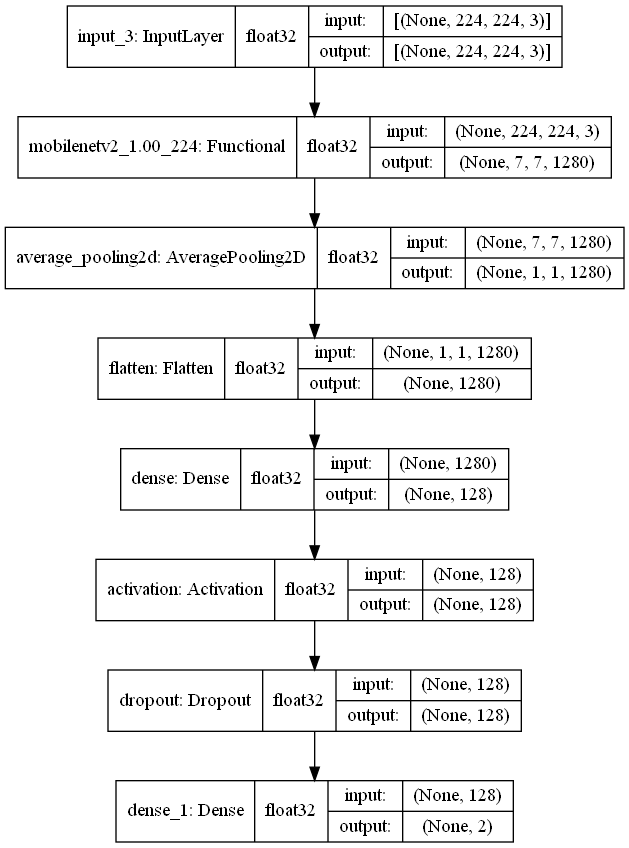

In [7]:
opt = keras.optimizers.Adam(learning_rate=3e-4, epsilon=1e-6)
# opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
reg = keras.regularizers.L2(1e-5)
epoch = 100
batch_size = 64
metrics = ['accuracy']
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=1,
                                     mode='auto', baseline=None, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('./best_model',monitor='val_accuracy',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=1, verbose=1)]
model.compile(optimizer=opt, loss=loss, metrics=metrics)
model.summary()
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, to_file='model.png')

In [8]:
history = model.fit(ImageGen.flow(train_x, train_y, batch_size=batch_size), steps_per_epoch=len(train_x)//batch_size, epochs=epoch,
                    validation_data=(val_x, val_y), validation_steps=len(val_x)//batch_size, callbacks=callbacks, verbose=1)

Epoch 1/100
238/238 [==============================] - 124s 500ms/step - loss: 0.2941 - accuracy: 0.9621 - val_loss: 0.2361 - val_accuracy: 0.9906

C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: .\best_model\assets
Epoch 2/100
238/238 [==============================] - 118s 496ms/step - loss: 0.2474 - accuracy: 0.9879 - val_loss: 0.2291 - val_accuracy: 0.9937

C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: .\best_model\assets
Epoch 3/100
238/238 [==============================] - 119s 500ms/step - loss: 0.2397 - accuracy: 0.9904 - val_loss: 0.2279 - val_accuracy: 0.9950

C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: .\best_model\assets
Epoch 4/100
238/238 [==============================] - 119s 499ms/step - loss: 0.2365 - accuracy: 0.9903 - val_loss: 0.2256 - val_accuracy: 0.9937

C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: .\best_model\assets
Epoch 8/100
238/238 [==============================] - 120s 503ms/step - loss: 0.2302 - accuracy: 0.9936 - val_loss: 0.2216 - val_accuracy: 0.9953

In [9]:
model = load_model('MobileNet mask')
model.predict(test_x[0])
test_y[0]

ValueError: in user code:

    C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1569 predict_function  *
        return step_function(self, iterator)
    C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Program Files\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Program Files\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Program Files\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1552 run_step  **
        outputs = model.predict_step(data)
    C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1525 predict_step
        return self(x, training=False)
    C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 224, 224, 3), found shape=(32, 3)


In [ ]:
model.evaluate(test_x, test_y)
model.save('MobileNet mask')